In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from IPython import display
import json

from collections import defaultdict

from sklearn.datasets import load_boston, load_breast_cancer, make_blobs, make_classification
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

from qpfs import QPFS
import nn_modules as nn
import nn_optimization as optim 
from optimization import GradientDescent, NesterovMomentum, ADAM
from load_data import *

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
cmap = sns.light_palette((210, 90, 60), 10, input="husl")
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20

### IRLS

In [114]:
class IRLS:
    def __init__(self, add_bias=True, qpfs=False, max_iter=100, tol=1e-6, verbose=True):
        self.add_bias = add_bias
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.qpfs = QPFS(sim='corr') if qpfs else None
        self._w_history = []
        self._loss_history = []
        self._acc_history = []
        self.msg = ''
    
    def fit(self, X, y):
        if self.add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        n_objects, n_features = X.shape
        self.w = 1. * np.random.randn(n_features)
        for i in range(self.max_iter):
            f = self.predict(X, add_bias=False)
            self._w_history.append(self.w)
            self._acc_history.append(accuracy_score(y, f > 0.5))
            self._loss_history.append(log_loss(y, f))
            w_old = self.w
            self.msg = 'iter: {}, acc: {:.2f}, loss: {:.4f}\n'.format(i, self._acc_history[-1], self._loss_history[-1])
            self.w = self._update_weights(X, y)
            if self.verbose:
                print(self.msg)
            if (np.sum((w_old - self.w) ** 2) / np.sum(self.w ** 2)) < self.tol:
                break
        self._w_history.append(self.w)
        self._acc_history.append(accuracy_score(y, f > 0.5))
        self._loss_history.append(log_loss(y, f))

    
    def _update_weights(self, X, y):
        f = self.predict(X, add_bias=False)
        n_features = X.shape[1]
        R = np.diag(np.maximum(1e-12, f * (1. - f)))
        if self.qpfs is None:
            hes = X.T.dot(R).dot(X)
            jac = X.T.dot(f - y)
            active_idxs = np.ones(n_features).astype(bool)
        else:
            F = np.sqrt(R).dot(X)
            z = (f - y) * np.sqrt(1. / np.maximum(1e-12, f * (1. - f)))
            self.qpfs.fit(F, z)
            self.msg += '\t ' + ' '.join(['{:.3f}'.format(s) for s in self.qpfs.score]) + '\n'
            self.msg += '\t b:' + ' '.join(['{:.3f}'.format(b) for b in self.qpfs.b.squeeze()]) + '\n'
            active_idxs = self.qpfs.score > np.min([0.01, (1. / 5 * n_features)])
            F = F[:, active_idxs]
            hes = F.T.dot(F)
            jac = F.T.dot(z)
        cond_1 = np.linalg.cond(hes)
        hes += .01 * np.eye(hes.shape[0])
        jac += .01 * self.w[active_idxs]
        cond_2 = np.linalg.cond(hes)
        self.msg += '\t cond before: {:.3f}, cond after: {:.3f}'.format(cond_1, cond_2) + '\n'
        hes_pinv = np.linalg.pinv(hes)
        w_update = np.zeros_like(self.w)
        w_update[active_idxs] = -hes_pinv.dot(jac)
        t = self._backtracking_linesearch(X, y, jac, w_update, active_idxs)
        return self.w + t * w_update
    
    def _backtracking_linesearch(self, X, y, jac, w_update, active_idxs, alpha=0.002, beta=0.8):
        t = 1
        loss_old = log_loss(y, self.predict(X, add_bias=False))
        for i in range(20):
            f = self.sigmoid(X.dot(self.w + t * w_update))
            if log_loss(y, f) < loss_old + alpha * t * w_update[active_idxs].dot(jac):
                break
            t = beta * t
        self.msg += f'\t t: {t:.4f}\n'
        return t
    
    @staticmethod
    def sigmoid(x):
        s = np.zeros_like(x)
        s[x >= 0] = 1. / (1 + np.exp(-x[x >= 0]))
        s[x < 0] = np.exp(x[x < 0]) / (np.exp(x[x < 0]) + 1.)
        return s

    def predict(self, X, add_bias=True):
        if self.add_bias and add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        return self.sigmoid(X.dot(self.w))
    
    def plot_w_updates(self, figsize):
        df = np.zeros((len(self.w), len(self._w_history) - 1))
        for i in range(len(self._w_history) - 1):
            w_prev = self._w_history[i]
            w_next = self._w_history[i + 1]
            df[:, i] = np.abs(w_next - w_prev)

        df = pd.DataFrame(df)

        plt.figure(figsize=figsize)
        sns.heatmap(df, cmap=cmap, vmin=0., vmax=1e-9, annot=True, cbar=False, fmt='.2f')

        plt.tight_layout()
        plt.show()

In [3]:
def nearest_point(x, y, X_grid, Y_grid):
    return np.argmin((Y_grid - y) ** 2), np.argmin((X_grid - x) ** 2)

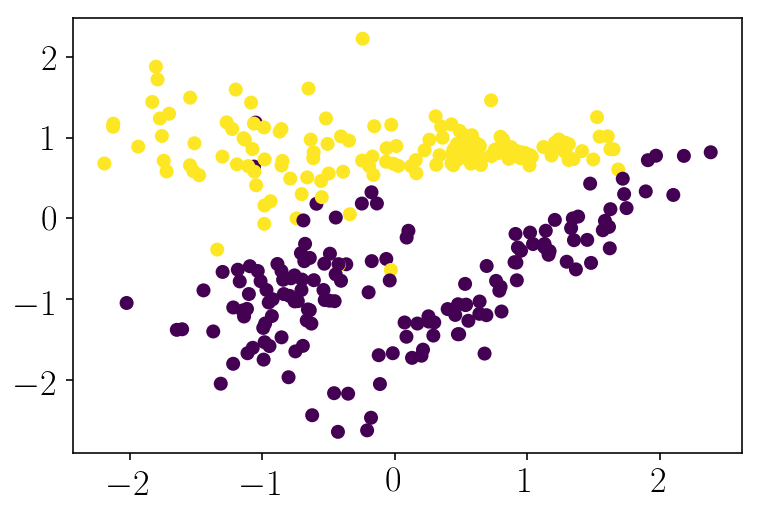

In [4]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, random_state=28)
X = (X - X.mean(0)) / X.std(axis=0)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [5]:
lr = LogisticRegression(C=7., fit_intercept=False)
lr.fit(X, y)
W_true = lr.coef_
np.random.seed(40)
W_near = W_true + 1. * np.random.randn(*W_true.shape)

In [6]:
irls = IRLS(add_bias=False, qpfs=True, max_iter=30)

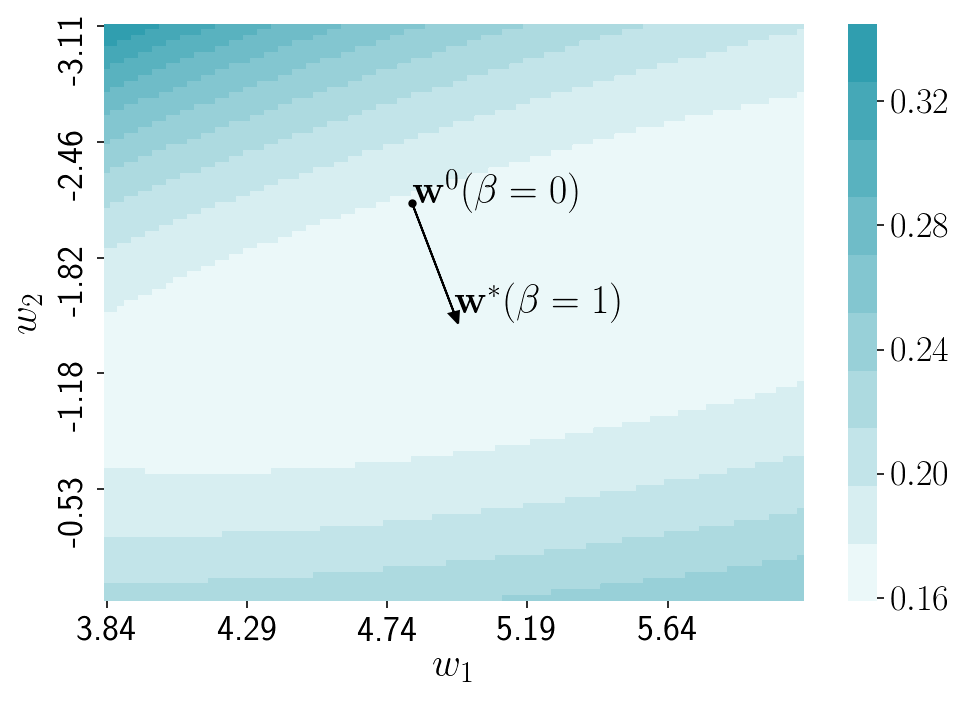

In [7]:
dw1, dw2 = np.abs(W_near - W_true).squeeze() + 1
i1, i2 = 0, 1
k_grid = 100

i1_x, i1_y = i1 // W_true.shape[1], i1 %  W_true.shape[1]
i2_x, i2_y = i2 // W_true.shape[1], i2 %  W_true.shape[1]
Z_grid = np.zeros((k_grid, k_grid))
X_grid = [W_true[i1_x, i1_y] - dw1 + 2 * i * dw1 / k_grid for i in range(k_grid)]
Y_grid = [W_true[i2_x, i2_y] - dw2 + 2 * j * dw2 / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        W = np.array([x_, y_])
        Z_grid[i, j] = log_loss(y, irls.sigmoid(X.dot(W)))
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(7, 5))
sns.heatmap(Z_grid, cmap=cmap, xticklabels=20, yticklabels=20)
idx_W_true = nearest_point(W_true[i1_x, i1_y], W_true[i2_x, i2_y], X_grid, Y_grid)
idx_W_near = nearest_point(W_near[i1_x, i1_y], W_near[i2_x, i2_y], X_grid, Y_grid)
plt.scatter(*idx_W_near, c='k', s=10)
plt.arrow(*idx_W_near, *[x1 - x2 for x1, x2 in zip(idx_W_true, idx_W_near)], 
          head_width=1.5, head_length=2., fc='k', ec='k')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.text(*idx_W_near, r'$\mathbf{w}^0 (\beta=0)$', fontsize=20)
plt.text(*idx_W_true, r'$\mathbf{w}^* (\beta=1)$', fontsize=20)

plt.tight_layout()
plt.savefig('figs/log_reg_error.eps', format='eps')
plt.show()

In [8]:
X, y = make_classification(n_samples=300, n_features=7, n_redundant=5, random_state=30)
X = (X - X.mean(0)) / X.std(axis=0)

lr = LogisticRegression(C=10000., fit_intercept=False)
lr.fit(X, y)
W_true = lr.coef_
np.random.seed(40)
W_near = W_true + 1. * np.random.randn(*W_true.shape)

In [9]:
irls = IRLS(add_bias=False, qpfs=True, max_iter=30)

irls.fit(X, y)

iter: 0, acc: 0.64, loss: 1.6617
	 0.000 0.000 0.000 0.000 1.000 0.000 0.000
	 b:0.001 0.001 0.000 0.001 0.006 0.000 0.001
	 cond before: 1.000, cond after: 1.000
	 t: 0.1074

iter: 1, acc: 0.59, loss: 0.6354
	 0.503 0.481 0.000 0.000 0.017 0.000 0.000
	 b:0.706 0.705 0.536 0.478 0.231 0.558 0.454
	 cond before: 2967.156, cond after: 493.844
	 t: 0.6400

iter: 2, acc: 0.91, loss: 0.3056
	 0.087 0.109 0.216 0.191 0.000 0.223 0.173
	 b:0.231 0.252 0.540 0.509 0.162 0.545 0.492
	 cond before: 167291567186584288.000, cond after: 1129.249
	 t: 0.0550

iter: 3, acc: 0.91, loss: 0.2988
	 0.081 0.114 0.218 0.192 0.000 0.226 0.169
	 b:0.223 0.243 0.528 0.497 0.157 0.533 0.480
	 cond before: 98350813740105680.000, cond after: 1074.255
	 t: 0.0859

iter: 4, acc: 0.90, loss: 0.2889
	 0.072 0.120 0.222 0.193 0.000 0.231 0.163
	 b:0.211 0.230 0.508 0.477 0.149 0.513 0.461
	 cond before: 208804604654550336.000, cond after: 993.567
	 t: 0.1342

iter: 5, acc: 0.91, loss: 0.2752
	 0.068 0.117 0.233 0.19

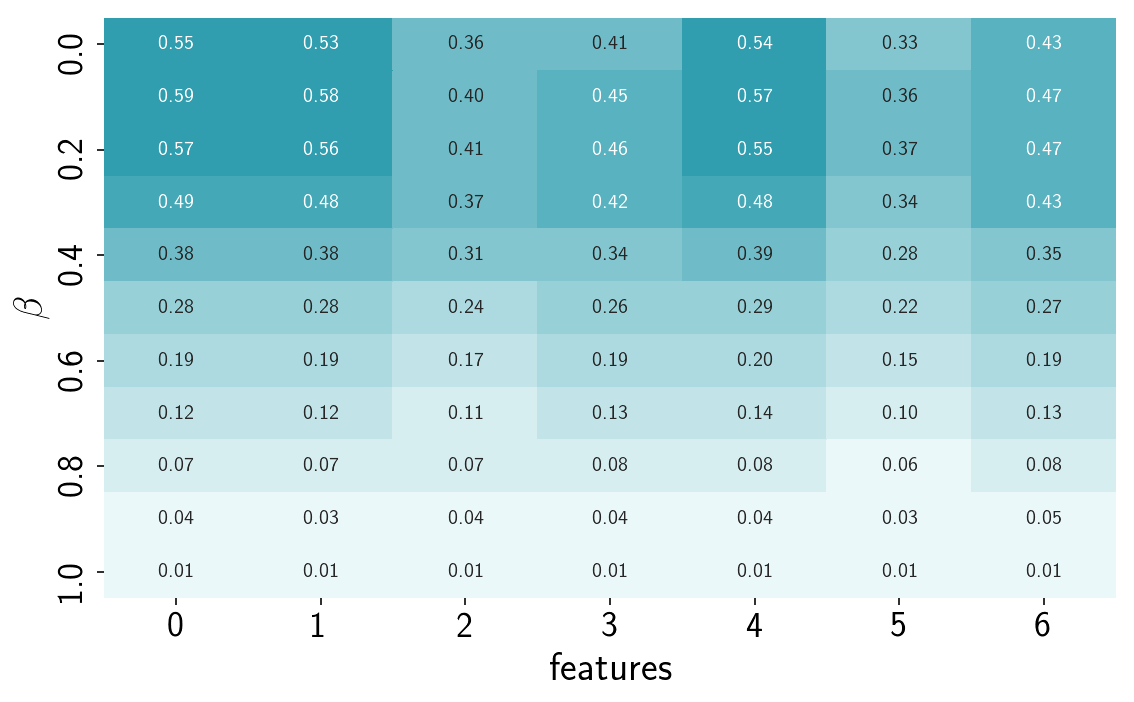

In [10]:
aff_coeffs = np.linspace(0, 1, 11)
Qs = []
bs = []
irls.verbose = False

for aff_coeff in aff_coeffs:
    W = (aff_coeff * W_true + (1 - aff_coeff) * W_near)
    irls.w = W.squeeze()
    irls._update_weights(X, y)
    bs.append(irls.qpfs.b.squeeze())
    Qs.append(irls.qpfs.Q)
    
plt.figure(figsize=(8, 5))
bs = pd.DataFrame(np.array(bs), index=aff_coeffs)
sns.heatmap(bs, cmap=cmap, cbar=False, yticklabels=2, annot=True, fmt='.2f')
plt.xlabel('features')
plt.ylabel(r'$\beta$')

plt.tight_layout()
plt.show()

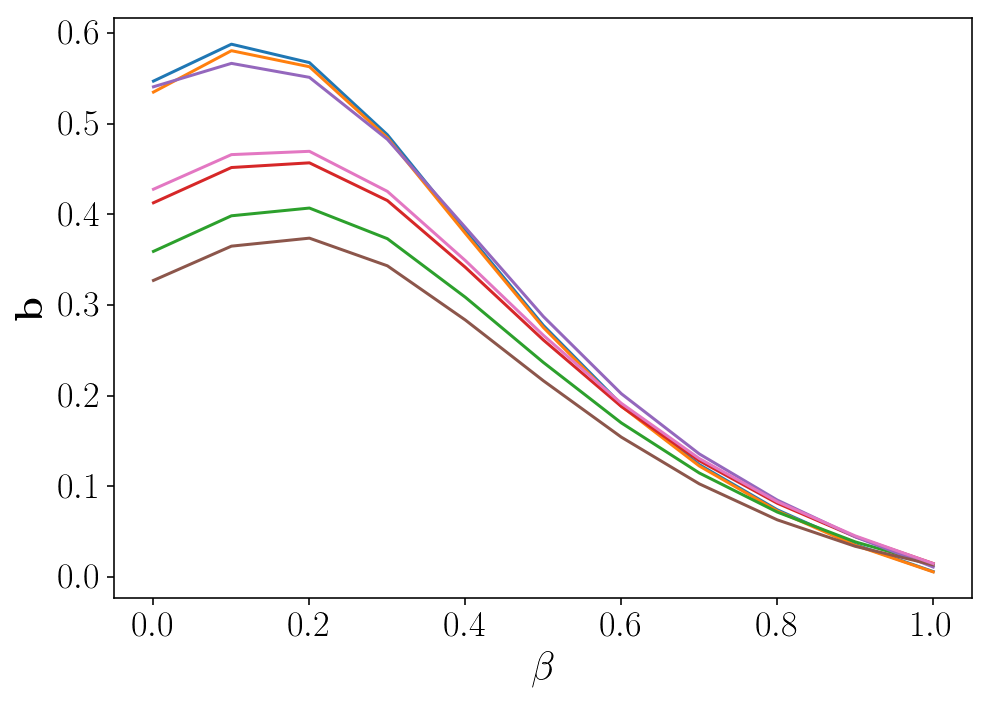

In [11]:
plt.figure(figsize=(7, 5))
plt.plot(bs)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\mathbf{b}$')
plt.tight_layout()
plt.savefig('figs/log_reg_b_wrt_beta.eps', format='eps')
plt.show()

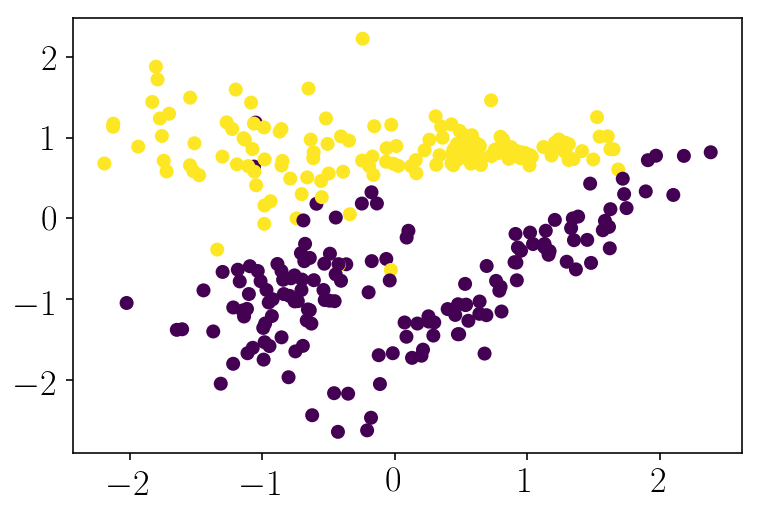

In [12]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, random_state=28)
X = (X - X.mean(0)) / X.std(axis=0)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [13]:
lr = LogisticRegression(fit_intercept=False, C=7.)
lr.fit(X, y)
y_pred = lr.predict(X)
print(np.mean(y == y_pred))
W_true = lr.coef_.squeeze()

0.953333333333


iter: 0, acc: 0.89, loss: 0.6029
	 0.000 1.000
	 b:0.006 0.009
	 cond before: 1.000, cond after: 1.000
	 t: 0.2621

iter: 1, acc: 0.87, loss: 0.5087
	 1.000 0.000
	 b:0.047 0.013
	 cond before: 1.000, cond after: 1.000
	 t: 0.8000

iter: 2, acc: 0.93, loss: 0.2120
	 0.315 0.685
	 b:0.041 0.061
	 cond before: 11.338, cond after: 10.317
	 t: 0.3277

iter: 3, acc: 0.94, loss: 0.1647
	 1.000 0.000
	 b:0.033 0.010
	 cond before: 1.000, cond after: 1.000
	 t: 0.8000

iter: 4, acc: 0.95, loss: 0.1593
	 0.000 1.000
	 b:0.008 0.016
	 cond before: 1.000, cond after: 1.000
	 t: 0.0115



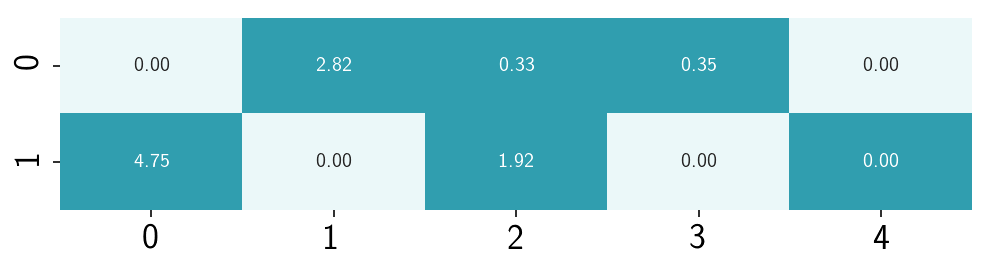

In [14]:
np.random.seed(53)
irls = IRLS(add_bias=False, qpfs=True, max_iter=50)
irls.fit(X, y)
irls.plot_w_updates((7, 2))

In [15]:
irls._w_history = [np.array([ 1.,  8.]),
 np.array([ 1.        ,  6.48274639]),
 np.array([-0.67897823,  6.48274639]),
 np.array([-1.13787791,  4.78396916]),
 np.array([-1.33691523,  4.78396916]),
 np.array([-1.33691523,  4.86693613]),
 np.array([-1.33691523,  4.8862326 ]),
 np.array([-1.33691523,  4.89023463])]

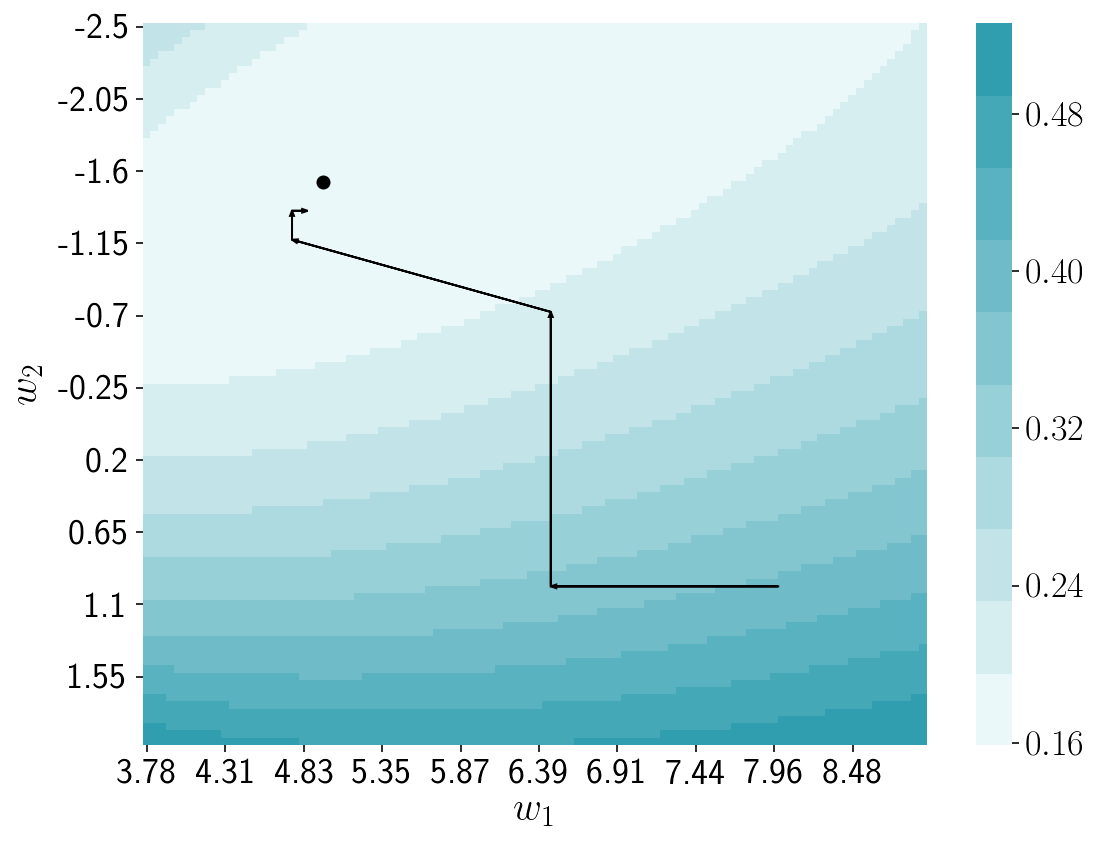

In [16]:
w1_min, w1_max = np.min([w[0] for w in irls._w_history]), np.max([w[0] for w in irls._w_history])
w2_min, w2_max = np.min([w[1] for w in irls._w_history]), np.max([w[1] for w in irls._w_history])

dw1_x, dw1_y = min(W_true[0], w1_min) - 1, max(W_true[0], w1_max) + 1
dw2_x, dw2_y = min(W_true[1], w2_min) - 1, max(W_true[1], w2_max) + 1
k_grid = 100

Z_grid = np.zeros((k_grid, k_grid))
X_grid = [dw1_x + i * (dw1_y - dw1_x) / k_grid for i in range(k_grid)]
Y_grid = [dw2_x + j * (dw2_y - dw2_x) / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        W = np.array([x_, y_])
        y_pred = irls.sigmoid(X.dot(W))
        Z_grid[i, j] = log_loss(y, y_pred)
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(8, 6))
sns.heatmap(Z_grid, cmap=cmap, xticklabels=10, yticklabels=10)
idx_W_true = nearest_point(W_true[0], W_true[1], X_grid, Y_grid)
plt.scatter(*idx_W_true, c='k')
idx_W_prev = nearest_point(irls._w_history[0][0], irls._w_history[0][1], X_grid, Y_grid)
for i in range(len(irls._w_history) - 1):
    idx_W_next = nearest_point(irls._w_history[i + 1][0], irls._w_history[i + 1][1], X_grid, Y_grid)
    arx, ary = idx_W_prev
    darx, dary = [x1 - x2 for x1, x2 in zip(idx_W_next, idx_W_prev)]
    if (darx != 0) or (dary != 0):
        plt.arrow(arx, ary, darx, dary, head_width=.5, head_length=.7, fc='k', ec='k', length_includes_head=True)
    idx_W_prev = idx_W_next
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')

plt.tight_layout()
plt.savefig('figs/irls_qpfs_2d.eps', format='eps')
plt.show()

### Gauss Newton

In [83]:
class GaussNewton:
    def __init__(self, n_hidden=2, add_bias=True, qpfs=False, max_iter=100, tol=1e-6, verbose=True):
        self.n_hidden = n_hidden
        self.add_bias = add_bias
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.qpfs = (QPFS(sim='corr'), QPFS(sim='corr')) if qpfs else None
        self._w_history = []
        self._loss_history = []
        self.msg = ''
        
    def predict(self, X, add_bias=True):
        if self.add_bias and add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        return self.sigmoid(X.dot(self.W1)).dot(self.W2)
    
    @staticmethod
    def sigmoid(x):
        s = np.zeros_like(x)
        s[x >= 0] = 1. / (1 + np.exp(-x[x >= 0]))
        s[x < 0] = np.exp(x[x < 0]) / (np.exp(x[x < 0]) + 1.)
        return s
    
    @staticmethod
    def dsigmoid(x):
        return np.exp(-x * np.sign(x)) / (1. + 2 * np.exp(-x * np.sign(x)) + np.exp(-2 * x * np.sign(x)))
    
    def fit(self, X, y):
        if self.add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        self.n_samples, self.n_features = X.shape
        self.W1 = 1. * np.random.randn(self.n_features, self.n_hidden)
        self.W2 = 1. * np.random.randn(self.n_hidden)
        for i in range(self.max_iter):
            f = self.predict(X, add_bias=False)
            self._w_history.append((self.W1, self.W2))
            self._loss_history.append(mean_squared_error(y, f))
            W1_old = self.W1
            W2_old = self.W2
            self.msg = 'iter: {}, mse: {:.4f}\n'.format(i, self._loss_history[-1])
            self.W1, self.W2 = self._update_weights(X, y, f, i)
            if self.verbose:
                print(self.msg)
                
            W1_diff = (np.sum((W1_old - self.W1) ** 2) / np.sum(self.W1 ** 2))
            W2_diff = (np.sum((W2_old - self.W2) ** 2) / np.sum(self.W2 ** 2))
            if (W1_diff < self.tol) and (W2_diff < self.tol):
                break
        self._w_history.append((self.W1, self.W2))
        self._loss_history.append(mean_squared_error(y, f))
        
    def _get_J1(self, X):
        J1 = np.zeros((self.n_samples, self.n_features * self.n_hidden))
        dfl = self.dsigmoid(X.dot(self.W1)) * self.W2.T
        for i in range(self.n_features):
            J1[:, i * self.n_hidden: (i + 1) * self.n_hidden] = X[:, [i]] * dfl
        return J1
        
    def _get_J2(self, X):
        return self.sigmoid(X.dot(self.W1))

    def _update_weights(self, X, y, f, it=1):
        J1 = self._get_J1(X)
        J2 = self._get_J2(X)
        
        if (self.qpfs is None) or (it % 50 == 0):
            active_idxs1 = np.ones(self.n_features * self.n_hidden).astype(bool)
            active_idxs2 = np.ones(self.n_hidden).astype(bool)
        else:
            self.qpfs[0].fit(J1, f - y)
            self.qpfs[1].fit(J2, f - y)
            self.msg += '\t ' + ' '.join(['{:.2f}'.format(s) for s in self.qpfs[0].score]) + '\n'
#             self.msg += '\t b:' + '\t ' + ' '.join(['{:.3f}'.format(b) for b in self.qpfs[0].b.squeeze()]) + '\n'
            self.msg += '\t ' + ' '.join(['{:.2f}'.format(s) for s in self.qpfs[1].score]) + '\n'
#             self.msg += '\t b:' + '\t ' + ' '.join(['{:.3f}'.format(b) for b in self.qpfs[1].b.squeeze()]) + '\n'
            
            active_idxs1 = self.qpfs[0].score > np.min([1e-2, (1. / 10 * self.n_features * self.n_hidden)])
            active_idxs2 = self.qpfs[1].score > np.min([1e-2, (1. / 10 * self.n_hidden)])
            active_idxs2 = np.ones(self.n_hidden).astype(bool)
            J1 = J1[:, active_idxs1]
            J2 = J2[:, active_idxs2]

        jac1 = J1.T.dot(f - y)
        hes1 = J1.T.dot(J1)

        jac2 = J2.T.dot(f - y)
        hes2 = J2.T.dot(J2)

        cond_hes1_1 = np.linalg.cond(hes1)
        hes1 += .01 * np.eye(hes1.shape[0])
        cond_hes1_2 = np.linalg.cond(hes1)
        
        cond_hes2_1 = np.linalg.cond(hes2)
        hes2 += .01 * np.eye(hes2.shape[0])
        cond_hes2_2 = np.linalg.cond(hes2)
        
        self.msg += '\t hes1 cond: {:.3f} / {:.3f}'.format(cond_hes1_1, cond_hes1_2) + '\n'
        self.msg += '\t hes2 cond: {:.3f} / {:.3f}'.format(cond_hes2_1, cond_hes2_2) + '\n'
        
        hes1_pinv = np.linalg.pinv(hes1)
        hes2_pinv = np.linalg.pinv(hes2)
        
        W1_update = np.zeros_like(self.W1)
        W2_update = np.zeros_like(self.W2)
        
        W1_update[active_idxs1.reshape((self.n_features, self.n_hidden))] = -hes1_pinv.dot(jac1)
        W2_update[active_idxs2] = -hes2_pinv.dot(jac2)
        
        t1, t2 = self._backtracking_linesearch(X, y, 
                                               (jac1, jac2), 
                                               (W1_update, W2_update), 
                                               (active_idxs1, active_idxs2)
                                              )
        return self.W1 + t1 * W1_update, self.W2 + t2 * W2_update
    
    def _backtracking_linesearch(self, X, y, jacs, W_updates, active_idxs, alpha=0.002, beta=0.8):
        t1 = 1.
        t2 = 1.
        loss_old = mean_squared_error(y, self.predict(X, add_bias=False))
        for i in range(20):
            f = self.sigmoid(X.dot(self.W1 + t1 * W_updates[0])).dot(self.W2)
            if mean_squared_error(y, f) < loss_old + alpha * t1 * W_updates[0].ravel()[active_idxs[0]].dot(jacs[0]):
                break
            t1 = beta * t1
        for i in range(20):
            f = self.sigmoid(X.dot(self.W1)).dot(self.W2 + t2 * W_updates[1])
            if mean_squared_error(y, f) < loss_old + alpha * t2 * W_updates[1][active_idxs[1]].dot(jacs[1]):
                break
            t2 = beta * t2
        self.msg += f'\t t1: {t1:.4f}'
        self.msg += f'\t t2: {t2:.4f}'
        return t1, t2
    
    def plot_w_updates(self, figsize):
        df = np.zeros((np.prod(self.W1.shape), len(self._w_history) - 1))
        for i in range(len(self._w_history) - 1):
            w_prev = self._w_history[i][0].ravel()
            w_next = self._w_history[i + 1][0].ravel()
            df[:, i] = np.abs(w_next - w_prev)

        df = pd.DataFrame(df)

        plt.figure(figsize=figsize)
        sns.heatmap(df, cmap=cmap, vmin=0., vmax=1e-9, annot=True, cbar=False, fmt='.2f')

        plt.tight_layout()
        plt.show()

In [18]:
X, y = load_boston(return_X_y=True)
X = (X - X.mean(axis=0)) / X.std(axis=0)
# X = X[:, :3]

In [19]:
np.random.seed(42)

gn = GaussNewton(n_hidden=2, add_bias=False, qpfs=False, verbose=False, max_iter=300)
gn.fit(X, y)
print(mean_squared_error(y, gn.predict(X)))

gn = GaussNewton(n_hidden=2, add_bias=False, qpfs=True, verbose=False, max_iter=300)
gn.fit(X, y)
print(mean_squared_error(y, gn.predict(X)))

20.1649024688
16.5082616563


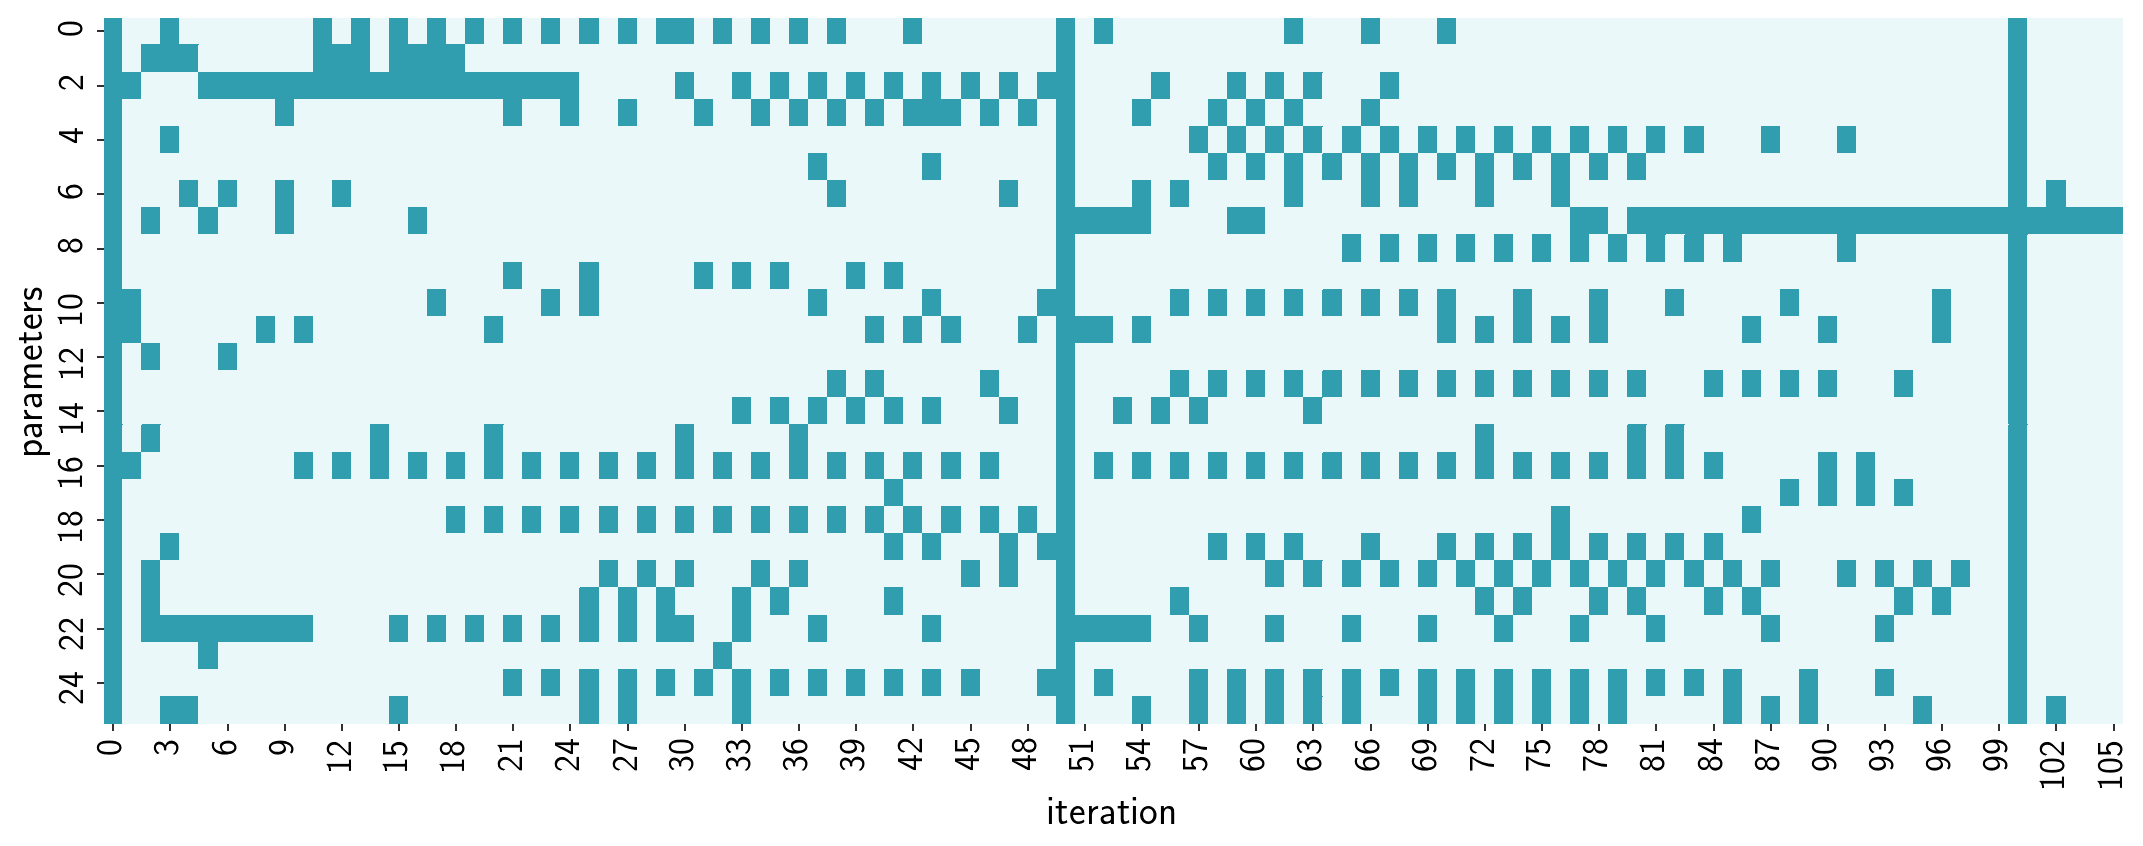

In [20]:
def plot_w_updates(self, figsize):
        df = np.zeros((np.prod(self.W1.shape), len(self._w_history) - 1))
        for i in range(len(self._w_history) - 1):
            w_prev = self._w_history[i][0].ravel()
            w_next = self._w_history[i + 1][0].ravel()
            df[:, i] = np.abs(w_next - w_prev) > 1e-12

        df = pd.DataFrame(df)

        plt.figure(figsize=figsize)
        sns.heatmap(df, cmap=cmap, vmin=0., vmax=1., cbar=False)
        plt.ylabel('parameters')
        plt.xlabel('iteration')
        plt.tight_layout()
        plt.savefig('figs/active_params_wrt_iters.eps', format='eps')
        plt.show()

plot_w_updates(gn, figsize=(15, 6))

In [21]:
W1_true = gn.W1
np.random.seed(30)
W1_near = W1_true + 1. * np.random.randn(*W1_true.shape)

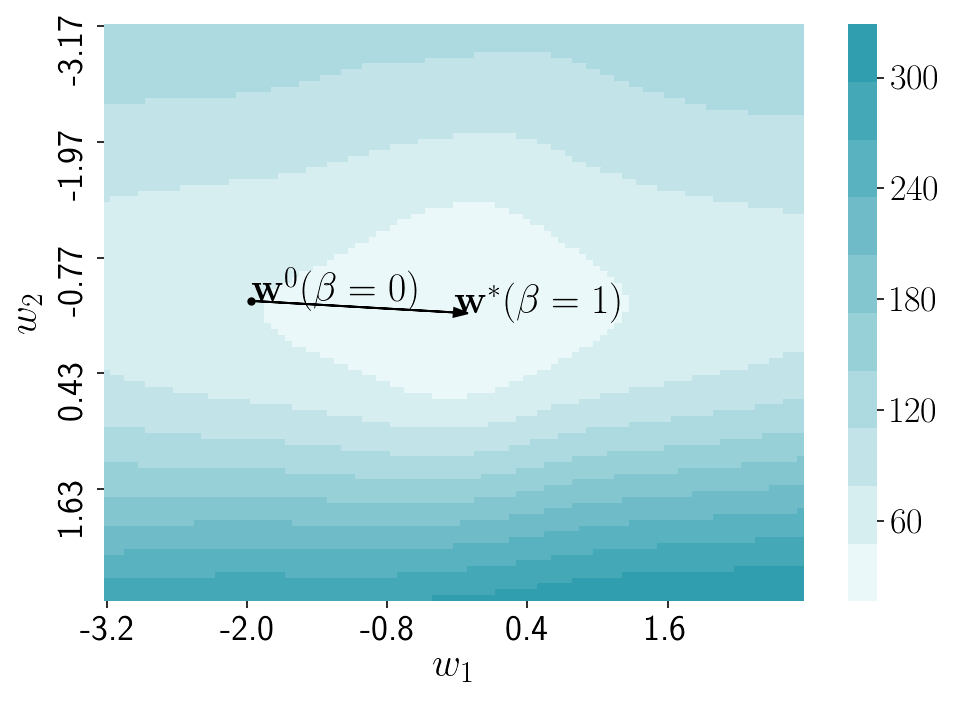

In [22]:
dw1, dw2 = 3., 3.
i1, i2 = 4, 6
k_grid = 100

i1_x, i1_y = i1 // W1_true.shape[1], i1 %  W1_true.shape[1]
i2_x, i2_y = i2 // W1_true.shape[1], i2 %  W1_true.shape[1]
Z_grid = np.zeros((k_grid, k_grid))
X_grid = [W1_true[i1_x, i1_y] - dw1 + 2 * i * dw1 / k_grid for i in range(k_grid)]
Y_grid = [W1_true[i2_x, i2_y] - dw2 + 2 * j * dw2 / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        W1 = W1_true.copy()
        W1[i1_x, i1_y] = x_
        W1[i2_x, i2_y] = y_
        Z_grid[i, j] = mean_squared_error(y, gn.sigmoid(X.dot(W1)).dot(gn.W2))
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(7, 5))
sns.heatmap(Z_grid, cmap=cmap, xticklabels=20, yticklabels=20)
idx_W1_true = nearest_point(W1_true[i1_x, i1_y], W1_true[i2_x, i2_y], X_grid, Y_grid)
idx_W1_near = nearest_point(W1_near[i1_x, i1_y], W1_near[i2_x, i2_y], X_grid, Y_grid)
plt.scatter(*idx_W1_near, c='k', s=10)
plt.arrow(*idx_W1_near, *[x1 - x2 for x1, x2 in zip(idx_W1_true, idx_W1_near)], 
          head_width=1.5, head_length=2., fc='k', ec='k')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.text(*idx_W1_near, r'$\mathbf{w}^0 (\beta=0)$', fontsize=20)
plt.text(*idx_W1_true, r'$\mathbf{w}^* (\beta=1)$', fontsize=20)

plt.tight_layout()
plt.savefig('figs/neural_error.eps', format='eps')
plt.show()

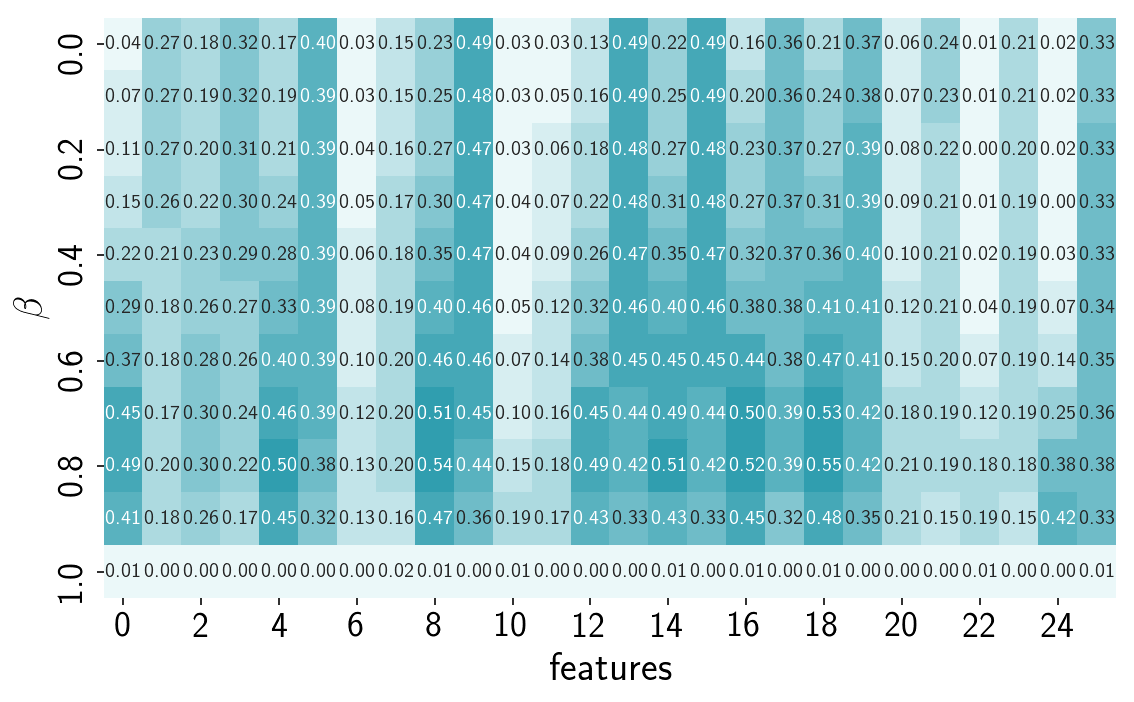

In [23]:
aff_coeffs = np.linspace(0, 1, 11)
Qs = []
bs = []
gn.verbose = False

for aff_coeff in aff_coeffs:
    W1 = (aff_coeff * W1_true + (1 - aff_coeff) * W1_near)
    gn.W1 = W1.squeeze()
    gn._update_weights(X, y, gn.predict(X))
    bs.append(gn.qpfs[0].b.squeeze())
    Qs.append(gn.qpfs[0].Q)
    
plt.figure(figsize=(8, 5))
bs = pd.DataFrame(np.array(bs), index=aff_coeffs)
sns.heatmap(bs, cmap=cmap, cbar=False, yticklabels=2, annot=True, fmt='.2f')
plt.xlabel('features')
plt.ylabel(r'$\beta$')

plt.tight_layout()
plt.show()

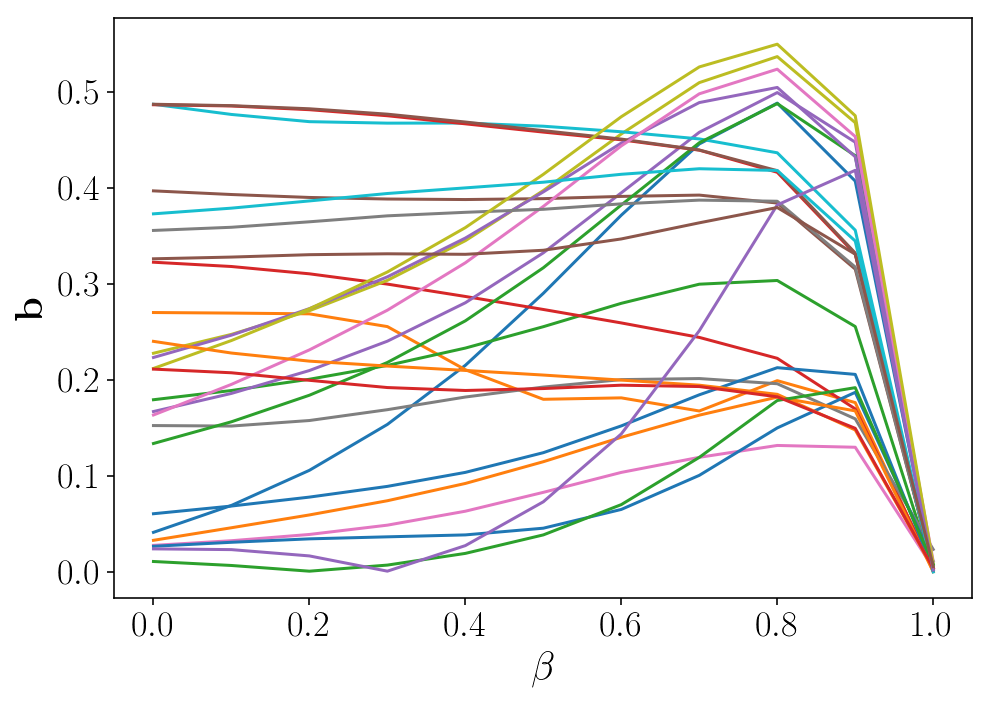

In [24]:
plt.figure(figsize=(7, 5))
plt.plot(bs)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\mathbf{b}$')
plt.tight_layout()
plt.savefig('figs/neural_b_wrt_beta.eps', format='eps')
plt.show()

In [25]:
np.random.seed(42)
gn = GaussNewton(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300)
gn.fit(X, y)
print('Newton: {:.4f}'.format(mean_squared_error(y, gn.predict(X))))
gn = GaussNewton(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)
gn.fit(X, y)
print('QPFS+Newton: {:.4f}'.format(mean_squared_error(y, gn.predict(X))))

/Users/romanisacenko/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1487: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


Newton: 125.5508
QPFS+Newton: 34.0468


In [26]:
from sklearn.neural_network import MLPRegressor

mlp_sgd = MLPRegressor(hidden_layer_sizes=2, activation='logistic', solver='sgd', learning_rate_init=0.1)
mlp_sgd.fit(X, y)

print('SGD: {:.4f}'.format(mean_squared_error(y, mlp_sgd.predict(X))))

mlp_adam = MLPRegressor(hidden_layer_sizes=2, activation='logistic', solver='adam', learning_rate_init=0.1)
mlp_adam.fit(X, y)

print('ADAM: {:.4f}'.format(mean_squared_error(y, mlp_adam.predict(X))))

mlp_adam = MLPRegressor(hidden_layer_sizes=2, activation='logistic', solver='lbfgs')
mlp_adam.fit(X, y)

print('LBFGS: {:.4f}'.format(mean_squared_error(y, mlp_adam.predict(X))))

SGD: 20.4668
ADAM: 15.8170
LBFGS: 11.3759


### Compare different optimizers (Nonlinear regression)

In [80]:
cv = KFold(n_splits=5, shuffle=True)
datasets = {'boston': load_bostonprices, 
            'community': load_community, 
            'forestfires': load_forestfires, 
            'residentialcost': load_residentialcost, 
            'residentialprice': load_residentialprice}

In [81]:
def get_scores(X, y, estimators, n_restarts, cv, metric, filename=None):
    results = defaultdict(list)
    for n_restart in range(n_restarts):
        for est in estimators:
            for train_idxs, test_idxs in cv.split(X):
                X_train, y_train = X[train_idxs], y[train_idxs]
                X_test, y_test = X[test_idxs], y[test_idxs]

                estimators[est].fit(X_train, y_train)

                pred = estimators[est].predict(X_train)
                results[est + '_' + str(n_restart) + '_' + 'train'].append(metric(y_train, pred))

                pred = estimators[est].predict(X_test)
                results[est + '_' + str(n_restart) + '_' + 'test'].append(metric(y_test, pred))
        print(f'Restart {n_restart} is finished')
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(json.dumps(results))
    return results

In [84]:
estimators = {'gd': GradientDescent(verbose=False, max_iter=300),
              'nesterov': NesterovMomentum(verbose=False, max_iter=300),
              'adam': ADAM(lr=.1, verbose=False, max_iter=300), 
              'gn': GaussNewton(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': GaussNewton(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_bostonprices()
print(X.shape)
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/boston.res')

(506, 13)
Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


In [86]:
estimators = {'gd': GradientDescent(verbose=False, max_iter=300),
              'nesterov': NesterovMomentum(verbose=False, max_iter=300),
              'adam': ADAM(lr=.1, verbose=False, max_iter=300), 
              'gn': GaussNewton(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': GaussNewton(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_community()
print(X.shape)
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/community.res')

(1994, 99)
Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


In [87]:
estimators = {#'gd': GradientDescent(verbose=False, max_iter=300),
              #'nesterov': NesterovMomentum(verbose=False, max_iter=300),
              #'adam': ADAM(lr=.1, verbose=False, max_iter=300), 
              #'gn': GaussNewton(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': GaussNewton(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_forestfires()
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/forestfires.res')

Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


In [88]:
estimators = {'gd': GradientDescent(verbose=False, max_iter=300),
              'nesterov': NesterovMomentum(verbose=False, max_iter=300),
              'adam': ADAM(lr=1., verbose=False, max_iter=300), 
              'gn': GaussNewton(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': GaussNewton(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_residentialcost()
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/residentialcost.res')

Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


In [89]:
estimators = {#'gd': GradientDescent(verbose=False, max_iter=300),
              #'nesterov': NesterovMomentum(verbose=False, max_iter=300),
              #'adam': ADAM(lr=.1, verbose=False, max_iter=300), 
              #'gn': GaussNewton(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': GaussNewton(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_residentialprice()
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/residentialprice.res')

Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


### Results

In [91]:
files = [
         './res/boston.res', 
         './res/community.res', 
         './res/forestfires.res', 
         './res/residentialcost.res', 
         './res/residentialprice.res'
        ]

for file in files:
    print(file)
    with open(file, 'r') as f:
        results = json.loads(f.read())
    for est in estimators:
        for r in range(5):
            key = est + '_' + str(r) + '_'
            print(' \t {} {} train {:.4f}+-{:.4f}'.format(est, r, 
                                                    np.mean(results[key + 'train']), np.std(results[key + 'train'])), end=' ')
            print('{} {} test {:.4f}+-{:.4f}'.format(est, r, 
                                                    np.mean(results[key + 'test']), np.std(results[key + 'test'])))

./res/boston.res
 	 gn_qpfs 0 train 21.9006+-6.1487 gn_qpfs 0 test 26.0157+-8.6520
 	 gn_qpfs 1 train 29.4709+-12.5078 gn_qpfs 1 test 32.9832+-8.9327
 	 gn_qpfs 2 train 20.9177+-10.4380 gn_qpfs 2 test 24.5422+-9.3926
 	 gn_qpfs 3 train 18.1824+-7.1090 gn_qpfs 3 test 24.4331+-4.0632
 	 gn_qpfs 4 train 27.3785+-7.1215 gn_qpfs 4 test 32.9189+-10.7141
./res/community.res
 	 gn_qpfs 0 train 0.0358+-0.0076 gn_qpfs 0 test 0.0385+-0.0078
 	 gn_qpfs 1 train 0.0400+-0.0245 gn_qpfs 1 test 0.0405+-0.0216
 	 gn_qpfs 2 train 0.0267+-0.0061 gn_qpfs 2 test 0.0284+-0.0070
 	 gn_qpfs 3 train 0.0336+-0.0110 gn_qpfs 3 test 0.0366+-0.0120
 	 gn_qpfs 4 train 0.0422+-0.0198 gn_qpfs 4 test 0.0465+-0.0215
./res/forestfires.res
 	 gn_qpfs 0 train 1.7972+-0.0490 gn_qpfs 0 test 2.0192+-0.2238
 	 gn_qpfs 1 train 1.7519+-0.0651 gn_qpfs 1 test 2.1376+-0.2387
 	 gn_qpfs 2 train 1.8241+-0.1919 gn_qpfs 2 test 2.0783+-0.2087
 	 gn_qpfs 3 train 1.7961+-0.1087 gn_qpfs 3 test 2.0633+-0.3982
 	 gn_qpfs 4 train 1.7381+-0.072

### Compare different optimizers (Classification)

In [93]:
from load_data_classification import *

cv = KFold(n_splits=5, shuffle=True)
datasets = {'breast': load_breast, 
            'cardiotocography': load_cardiotocography, 
            'climate': load_climate}

In [115]:
estimators = {'gd': GradientDescent(verbose=False, max_iter=300),
              'nesterov': NesterovMomentum(verbose=False, max_iter=300),
              'adam': ADAM(lr=1e-2, verbose=False, max_iter=300), 
              'irls': IRLS(add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'irls_qpfs': IRLS(add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_breast()
print(X.shape)
get_scores(X, y, estimators, 1, cv, log_loss, './res/breast.res')

(569, 30)
Restart 0 is finished


defaultdict(list,
            {'adam_0_test': [0.053477100420625145,
              0.081915327782120739,
              0.17534744260273602,
              0.057348049529706728,
              0.19406399025842611],
             'adam_0_train': [0.052753464410245823,
              0.10212185431693328,
              0.083796955579300017,
              0.093415273751133981,
              0.034738499019035717],
             'gd_0_test': [0.93624404491482027,
              0.77757965398629791,
              0.78623152928031237,
              1.0584231811549238,
              1.4284193593033478],
             'gd_0_train': [0.5650670141902685,
              1.053925600059157,
              0.96293886569567289,
              0.94087976364299664,
              1.6788517619265024],
             'irls_0_test': [0.35501167362849384,
              0.58872878772703929,
              0.2084420201848293,
              0.078897490791513272,
              0.15011950267199548],
             'irls_0_train':

In [95]:
X, y = load_breast()

In [110]:
gd = ADAM(lr=1e-2)
gd.fit(X, y)

iter: 0, acc: 0.79, loss: 0.6785

iter: 1, acc: 0.80, loss: 0.6525

iter: 2, acc: 0.80, loss: 0.6277

iter: 3, acc: 0.81, loss: 0.6040

iter: 4, acc: 0.82, loss: 0.5815

iter: 5, acc: 0.82, loss: 0.5601

iter: 6, acc: 0.83, loss: 0.5398

iter: 7, acc: 0.84, loss: 0.5205

iter: 8, acc: 0.85, loss: 0.5022

iter: 9, acc: 0.85, loss: 0.4849

iter: 10, acc: 0.85, loss: 0.4685

iter: 11, acc: 0.86, loss: 0.4530

iter: 12, acc: 0.86, loss: 0.4382

iter: 13, acc: 0.87, loss: 0.4243

iter: 14, acc: 0.87, loss: 0.4111

iter: 15, acc: 0.87, loss: 0.3986

iter: 16, acc: 0.88, loss: 0.3867

iter: 17, acc: 0.88, loss: 0.3753

iter: 18, acc: 0.88, loss: 0.3645

iter: 19, acc: 0.89, loss: 0.3542

iter: 20, acc: 0.89, loss: 0.3443

iter: 21, acc: 0.89, loss: 0.3349

iter: 22, acc: 0.89, loss: 0.3259

iter: 23, acc: 0.90, loss: 0.3172

iter: 24, acc: 0.90, loss: 0.3088

iter: 25, acc: 0.90, loss: 0.3008

iter: 26, acc: 0.91, loss: 0.2931

iter: 27, acc: 0.91, loss: 0.2856

iter: 28, acc: 0.91, loss: 0.2

In [98]:
class GradientDescent:
    def __init__(self, lr=1e-3, add_bias=True, max_iter=100, tol=1e-6, verbose=True):
        self.lr = lr
        self.add_bias = add_bias
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self._w_history = []
        self._loss_history = []
        self._acc_history = []
        self.msg = ''
    
    def fit(self, X, y):
        if self.add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        n_objects, n_features = X.shape
        self.w = 10. * np.random.randn(n_features)
        for i in range(self.max_iter):
            f = self.predict(X, add_bias=False)
            self._w_history.append(self.w)
            self._acc_history.append(accuracy_score(y, f > 0.5))
            self._loss_history.append(log_loss(y, f))
            w_old = self.w
            self.msg = 'iter: {}, acc: {:.2f}, loss: {:.4f}\n'.format(i, self._acc_history[-1], self._loss_history[-1])
            self.w = self._update_weights(X, y)
            if self.verbose:
                print(self.msg)
            if (np.sum((w_old - self.w) ** 2) / np.sum(self.w ** 2)) < self.tol:
                break
        self._w_history.append(self.w)
        self._acc_history.append(accuracy_score(y, f > 0.5))
        self._loss_history.append(log_loss(y, f))

    
    def _update_weights(self, X, y):
        f = self.predict(X, add_bias=False)
        n_features = X.shape[1]
        jac = X.T.dot(f - y)

        w_update = -self.lr * jac
        return self.w + w_update
    
    @staticmethod
    def sigmoid(x):
        s = np.zeros_like(x)
        s[x >= 0] = 1. / (1 + np.exp(-x[x >= 0]))
        s[x < 0] = np.exp(x[x < 0]) / (np.exp(x[x < 0]) + 1.)
        return s

    def predict(self, X, add_bias=True):
        if self.add_bias and add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        return self.sigmoid(X.dot(self.w))

In [105]:
class NesterovMomentum:
    def __init__(self, lr=1e-3, momentum = 0.9, add_bias=True, max_iter=100, tol=1e-6, verbose=True):
        self.lr = lr
        self.momentum = momentum
        self.add_bias = add_bias
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self._w_history = []
        self._loss_history = []
        self._acc_history = []
        self.msg = ''
    
    def fit(self, X, y):
        if self.add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        n_objects, n_features = X.shape
        self.w = 1. * np.random.randn(n_features)
        self.v = np.zeros_like(self.w)
        for i in range(self.max_iter):
            f = self.predict(X, add_bias=False)
            self._w_history.append(self.w)
            self._acc_history.append(accuracy_score(y, f > 0.5))
            self._loss_history.append(log_loss(y, f))
            w_old = self.w
            self.msg = 'iter: {}, acc: {:.2f}, loss: {:.4f}\n'.format(i, self._acc_history[-1], self._loss_history[-1])
            self.w = self._update_weights(X, y)
            if self.verbose:
                print(self.msg)
            if (np.sum((w_old - self.w) ** 2) / np.sum(self.w ** 2)) < self.tol:
                break
        self._w_history.append(self.w)
        self._acc_history.append(accuracy_score(y, f > 0.5))
        self._loss_history.append(log_loss(y, f))

    
    def _update_weights(self, X, y):
        f = self.predict(X, add_bias=False)
        n_features = X.shape[1]
        jac = X.T.dot(f - y)
        self.v = self.momentum * self.v - self.lr * jac
        v_prev = self.v.copy()

        w_update = -self.momentum * v_prev + (1. + self.momentum) * self.v
        return self.w + w_update
    
    @staticmethod
    def sigmoid(x):
        s = np.zeros_like(x)
        s[x >= 0] = 1. / (1 + np.exp(-x[x >= 0]))
        s[x < 0] = np.exp(x[x < 0]) / (np.exp(x[x < 0]) + 1.)
        return s

    def predict(self, X, add_bias=True):
        if self.add_bias and add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        return self.sigmoid(X.dot(self.w))

In [108]:
class ADAM:
    def __init__(self, lr=1e-3, eps=1e-8, beta1=0.9, beta2=0.999, 
                 add_bias=True, max_iter=100, tol=1e-6, verbose=True):
        self.lr = lr
        self.eps = eps
        self.beta1 = beta1
        self.beta2 = beta2
        self.add_bias = add_bias
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self._w_history = []
        self._loss_history = []
        self._acc_history = []
        self.msg = ''
    
    def fit(self, X, y):
        if self.add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        n_objects, n_features = X.shape
        self.w = 1. * np.random.randn(n_features)
        self.v = np.zeros_like(self.w)
        self.m = np.zeros_like(self.w)
        for i in range(self.max_iter):
            f = self.predict(X, add_bias=False)
            self._w_history.append(self.w)
            self._acc_history.append(accuracy_score(y, f > 0.5))
            self._loss_history.append(log_loss(y, f))
            w_old = self.w
            self.msg = 'iter: {}, acc: {:.2f}, loss: {:.4f}\n'.format(i, self._acc_history[-1], self._loss_history[-1])
            self.w = self._update_weights(X, y, i)
            if self.verbose:
                print(self.msg)
            if (np.sum((w_old - self.w) ** 2) / np.sum(self.w ** 2)) < self.tol:
                break
        self._w_history.append(self.w)
        self._acc_history.append(accuracy_score(y, f > 0.5))
        self._loss_history.append(log_loss(y, f))

    
    def _update_weights(self, X, y, i):
        f = self.predict(X, add_bias=False)
        n_features = X.shape[1]
        jac = X.T.dot(f - y)
        
        self.m = self.beta1 * self.m + (1. - self.beta1) * jac
        mt = self.m / (1 - self.beta1 ** (i + 1))
        self.v = self.beta2 * self.v + (1 - self.beta2) * (jac ** 2)
        vt = self.v / (1 - self.beta2 ** (i + 1))
        w_update = -self.lr * mt / (np.sqrt(vt) + self.eps)
        return self.w + w_update
    
    @staticmethod
    def sigmoid(x):
        s = np.zeros_like(x)
        s[x >= 0] = 1. / (1 + np.exp(-x[x >= 0]))
        s[x < 0] = np.exp(x[x < 0]) / (np.exp(x[x < 0]) + 1.)
        return s

    def predict(self, X, add_bias=True):
        if self.add_bias and add_bias:
            X = np.hstack([X, np.ones((X.shape[0], 1))])
        return self.sigmoid(X.dot(self.w))